## Kaggle Titanic 模型Ensembling

### 一、读取数据

In [355]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print(train.shape)
print(train.columns)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


#### **一共有891个样本，每个样本含有12个特征，包括护照id，是否存活，名字，性别，年龄等等**

In [356]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 二、开始清洗数据，进行特征工程
- 将名字特征转化为长度数值
- 根据Cabin特征增加Has_cabin特征，值为0和1，代表是否有Cabin
- SibSp代表船上是否有兄弟姐妹和配偶
- Parch代表船上是否有父母和子女
- 新增FamilySize代表家人数量
- Embarked缺失值用0填充
- Fare缺失值用中位数填充
- Age缺失值采用均值和标准差产生的随机数填充
- Age通过pd.cut进行分桶处理
- 通过名字获取人的头衔，比如Mr,Miss等

In [357]:
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''
full_data = [train, test]
for dataset in full_data:
    dataset['Name_length'] = dataset['Name'].apply(len)
    dataset['Has_cabin'] = dataset['Cabin'].apply(lambda x : 0 if type(x) == float else 1)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
    dataset['Age'] = dataset['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std, size = 1)[0])
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms', 'Mme'], 'Miss')
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Sex'] = dataset['Sex'].map({'female' : 0, 'male' : 1}).astype(int)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    # Mapping Fare
    Fare_bins = [-float('inf'), 7.91, 14.454, 31, float('inf')]
    dataset['Fare'] = pd.cut(dataset['Fare'], Fare_bins, labels = [0, 1, 2, 3])
    dataset['Fare'] = dataset['Fare'].astype(int)
    age_bins = [-float('inf'), 16, 32, 48, 64, float('inf')]
    dataset['Age'] = pd.cut(dataset['Age'], age_bins, labels = [0, 1, 2, 3, 4])

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,0,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,1,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,22,0,1,1,2


#### 删除不需要的特征列

In [358]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
PassengerId = test['PassengerId']
train = train.drop(drop_elements, axis = 1)
test = test.drop(drop_elements, axis = 1)
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


#### 首先看下特征之间的相关性，尽量使用不相关的特征

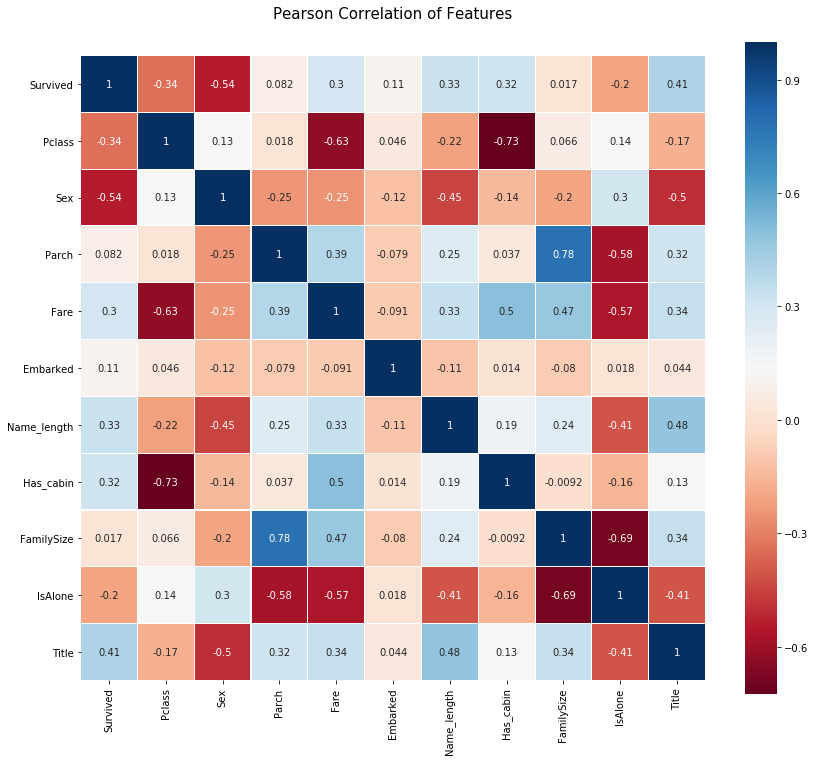

In [359]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
train.corr(method='pearson')
sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

### 三、使用多个模型训练

- get_oof函数用来实现模型的stacking， 五折交叉验证，每次测试集取五分之一，最后合起来就是train data的大小，然后五次test预测取均值，接下来利用模型预测的结果作为第二阶段模型的训练集，即oof_train，而oof_test作为第二阶段测试集，第一阶段使用的模型如下：

    1. Random Forest classifier
    2. Extra Trees classifier
    3. AdaBoost classifer
    4. Gradient Boosting classifer
    5. Support Vector Machine

In [360]:
ntrain = train.shape[0]
ntest = test.shape[0]
NFOLDS = 5 
kf = KFold(ntrain, n_folds= NFOLDS)
class SklearnHelper(object):
    def __init__(self, estimator, params=None):
        self.estimator = estimator
        self.params = params

    def train(self, x_train, y_train):
        self.clf = GridSearchCV(self.estimator, self.params, cv = 5, refit = True, n_jobs = -1)
        self.clf.fit(x_train, y_train)
    def predict(self, x):
        return self.clf.predict(x)
    
    def feature_importances(self):
        return self.clf.best_estimator_.feature_importances_
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

#### 模型参数设置，通过GridsearchCV进行交叉验证自动调差

In [361]:
# Random Forest parameters
rf_params = {
    'n_estimators': np.arange(400, 500, 100),
    'max_depth': np.arange(3, 7, 1),
    'min_samples_leaf': np.arange(1, 3, 1),
    'max_features' : np.arange(3, 4, 1)

}

# Extra Trees Parameters
et_params = {
    'n_estimators': np.arange(400, 500, 50),
    'max_depth': np.arange(5, 8, 1),
    'min_samples_leaf': np.arange(2, 3, 1)
}

# AdaBoost parameters
ada_params = {
    'n_estimators': np.arange(400, 500, 50),
    'learning_rate' : np.arange(0.55, 0.75, 0.05)
}
# Gradient Boosting parameters
gb_params = {
    'n_estimators': np.arange(400, 500, 50),
    'max_depth': np.arange(5, 8, 1),
    'min_samples_leaf': np.arange(1, 4, 1)
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : ['linear'],
    'C' : np.arange(0.025, 0.5, 0.05)
    }
rf = SklearnHelper(estimator=RandomForestClassifier(),params=rf_params)
et = SklearnHelper(estimator=ExtraTreesClassifier(), params=et_params)
ada = SklearnHelper(estimator=AdaBoostClassifier(), params=ada_params)
gb = SklearnHelper(estimator=GradientBoostingClassifier(), params=gb_params)
svc = SklearnHelper(estimator=SVC(), params=svc_params)
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values 
x_test = test.values 

#### 开始进行训练

In [362]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


#### 第一阶段训练完模型之后，我们可以通过调用feature_importances_来衡量每个模型中每个特征的重要性，可视化后如下图所示

In [364]:
rf_features = rf.feature_importances()
et_features = et.feature_importances()
ada_features = ada.feature_importances()
gb_features = gb.feature_importances()
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

### 四、开始训练第二阶段模型
#### 将第一阶段四个模型预测结果构建一个Dataframe做为第二阶段模型的训练数据，然后可视化衡量特征之间的相关性

In [369]:
second_train = pd.DataFrame({'RandomForest' : rf_oof_train.ravel(), 
                             'ExtraTrees' : et_oof_train.ravel(),
                             'AdaBoost' : ada_oof_train.ravel(),
                             'GradientBoost' : gb_oof_train.ravel()})
second_train.head(3)

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0


In [371]:
data = [
    go.Heatmap(
        z= second_train.astype(float).corr().values ,
        x=second_train.columns.values,
        y= second_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

#### 开始训练第二阶段的模型

In [375]:
test = pd.read_csv('./data/test.csv')
PassengerId = test['PassengerId']
second_train_X = np.concatenate((rf_oof_train, et_oof_train, ada_oof_train, gb_oof_train), axis=1)
second_test_x = np.concatenate((rf_oof_test, et_oof_test, ada_oof_test, gb_oof_test), axis=1)
gbm = xgb.XGBClassifier(
    learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(second_train_X, y_train)
predictions = gbm.predict(second_test_x)
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)
print('可以提交结果了')

可以提交结果了
